#Student Name: Rahul Deshmukh
#ECE 595 Machine Learning II
#Project 4: Adversarial Machine Learning - Student Code

In [0]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

In [0]:
#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
from keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2
import pickle 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Part 1: Training a target classifier

In [0]:
# Load data MNIST data and normalize to [0, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = data_train/255.0
data_test = data_test/255.0

#Reshape training and testing data into 784-dimensional vectors 
X_train= data_train.reshape(60000,784)
X_test= data_test.reshape(10000,784)

#Convert integer labels for training and testing data into one-hot vectors 
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)

In [0]:
#Create classifier architecture, compile it, and train it
def MNIST_Classifier():    
    model = Sequential()
    model.add(Dense(100,activation='relu',input_dim=784))
    model.add(BatchNormalization())
    model.add(Dense(100,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10,activation='softmax'))
    return model

In [0]:
#Create instance of classifier
mnist_classifier = MNIST_Classifier()

#Compile model using an appropriate loss and optimizer algorithm
mnist_classifier.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

#Train the model and assign training meta-data to a variable
mnist_classifier_mdata = mnist_classifier.fit(X_train,labels_train,
                                         validation_data=(X_test,labels_test),
                                         epochs=50,
                                         batch_size=256,
                                         shuffle=True)

# save model and history
mnist_classifier.save('mnist_classifier.h5')
!cp mnist_classifier.h5 /content/gdrive/My\ Drive/ML2/Project-4/

with open('mnist_classifier_history.pkl', 'wb') as f:  
  pickle.dump(mnist_classifier_mdata.history, f)

!cp mnist_classifier_history.pkl /content/gdrive/My\ Drive/ML2/Project-4/

W1107 22:56:15.115520 140542455551872 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1107 22:56:15.334399 140542455551872 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1107 22:56:15.434782 140542455551872 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1107 22:56:15.530695 140542455551872 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Se

Train on 60000 samples, validate on 10000 samples
Epoch 1/50


W1107 22:56:15.813371 140542455551872 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



60000/60000 [==============================] - 3s 55us/step - loss: 0.3107 - acc: 0.9093 - val_loss: 0.1425 - val_acc: 0.9577
Epoch 2/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.1159 - acc: 0.9660 - val_loss: 0.1110 - val_acc: 0.9657
Epoch 3/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0794 - acc: 0.9769 - val_loss: 0.0933 - val_acc: 0.9694
Epoch 4/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0581 - acc: 0.9832 - val_loss: 0.0903 - val_acc: 0.9729
Epoch 5/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0442 - acc: 0.9871 - val_loss: 0.0838 - val_acc: 0.9754
Epoch 6/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0329 - acc: 0.9909 - val_loss: 0.0829 - val_acc: 0.9741
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0270 - acc: 0.9920 - val_loss: 0.0911 - val_acc: 0.9726
Epoch 8/50
60000/60000 [============================

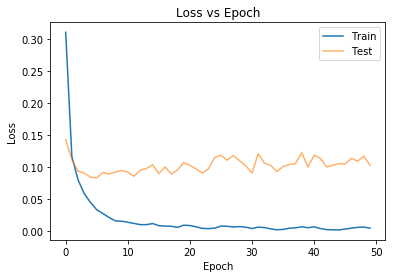

In [0]:
# load saved model and history
!cp /content/gdrive/My\ Drive/ML2/Project-4/mnist_classifier.h5 ./
!cp /content/gdrive/My\ Drive/ML2/Project-4/mnist_classifier_history.pkl ./

mnist_classifier = load_model('mnist_classifier.h5')

with open('mnist_classifier_history.pkl', 'rb') as f:  
 mnist_classifier_history = pickle.load(f)

#Plot loss vs epoch
plt.plot(mnist_classifier_history['loss'])
plt.plot(mnist_classifier_history['val_loss'],alpha = 0.6)
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper right')
plt.show()

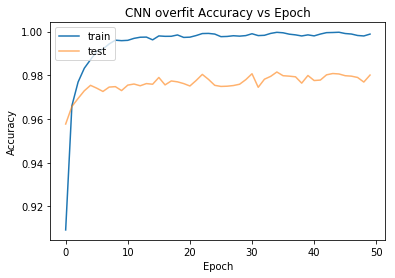

In [0]:
#Plot accuracy vs epoch
plt.plot(mnist_classifier_history['acc'])
plt.plot(mnist_classifier_history['val_acc'],alpha = 0.6)
plt.title('CNN overfit Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [0]:
#Print accuracy of classifier on MNIST testing data
score = mnist_classifier.evaluate(X_test,labels_test)
print("Accuracy of Classifier: %0.2f%%"%(score[1]*100))

10000/10000 [==============================] - 0s 43us/step
Accuracy of Classifier: 98.01%


In [0]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
# classifier from above and then run this block
!cp /content/gdrive/My\ Drive/ML2/Project-4/mnist_classifier.h5 ./
mnist_classifier = load_model('mnist_classifier.h5')

#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(mnist_classifier)

#Part 2: The Fast Gradient Method (FGM)

In [0]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
fgsm = FastGradientMethod(wrap,sess=sess)

#Attack parameters
fgsm_params = { 'eps':0.25,
                'clip_min':0.,
                'clip_max':1.}

#Generate adversarial data
fgsm_attack_onTest_data = fgsm.generate_np(X_test,**fgsm_params)
fgsm_attack_onTrain_data = fgsm.generate_np(X_train,**fgsm_params)

#Evaluate accuracy on target classifier 
fgsm_adv_scores = mnist_classifier.evaluate(fgsm_attack_onTest_data,labels_test)
print('FGSM Adversarial Attack Accuracy: %0.2f%%'%(fgsm_adv_scores[1]*100))

10000/10000 [==============================] - 1s 82us/step
FGSM Adversarial Attack Accuracy: 8.79%


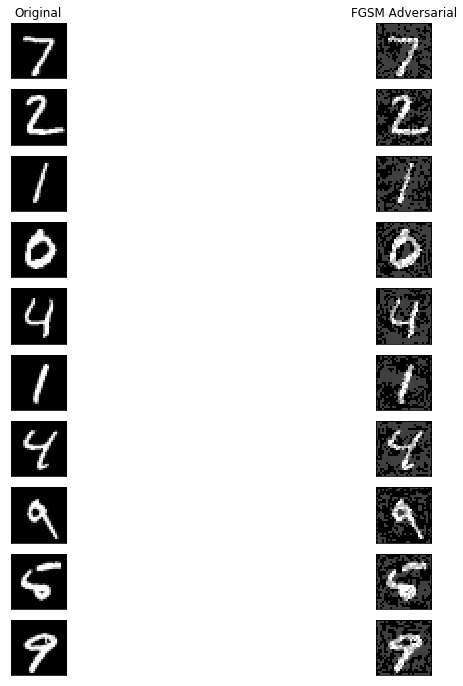

In [0]:
#Show ten original samples and their corresponding adversarial samples
num_samples = 10
fig1,ax1 = plt.subplots(num_samples,2)
fig1.set_size_inches(12,12)
titles=['Original','FGSM Adversarial']
for i in range(2): ax1[0,i].set_title(titles[i])
for i in range(num_samples):
  #original 
  ax1[i,0].imshow(X_test[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,0].get_xaxis().set_visible(False)
  ax1[i,0].get_yaxis().set_visible(False)
  #adversarial
  ax1[i,1].imshow(fgsm_attack_onTest_data[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,1].get_xaxis().set_visible(False)
  ax1[i,1].get_yaxis().set_visible(False)

plt.show()

In [0]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation='relu', kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(100, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(400, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer

#Create deep autoencoder graph
ae_fgsm = autoencoder()

#Compile model using an appropriate loss and optimizer algorithm
ae_fgsm.compile(loss="mean_squared_error",optimizer="adam")

#Train the model and assign training meta-data to a variable
num_epochs = 50
batch_size = 256

ae_fgsm_history = ae_fgsm.fit(X_train,X_train,
                             epochs = num_epochs,
                             batch_size = batch_size,
                             shuffle=True)

# save model
ae_fgsm.save('ae_fgsm.h5')
!cp ae_fgsm.h5 /content/gdrive/My\ Drive/ML2/Project-4/

W1111 18:00:06.427733 140222605977472 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.0539
Epoch 2/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0213
Epoch 3/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0159
Epoch 4/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0133
Epoch 5/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0116
Epoch 6/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0104
Epoch 7/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0095
Epoch 8/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0088
Epoch 9/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0081
Epoch 10/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0077
Epoch 11/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0072
Epoch 12/50
60000/60000 [===========================

In [0]:
# load ae_fgsm model
!cp /content/gdrive/My\ Drive/ML2/Project-4/ae_fgsm.h5 ./
ae_fgsm = load_model('ae_fgsm.h5')

#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
# fgsm_attack_onTrain_data = fgsm.generate_np(X_train,**fgsm_params)

# Obtain reconstruction errors on training set and determine a threshold 
reconstructions_ae_fgsm_onTrain_data = ae_fgsm.predict(fgsm_attack_onTrain_data)
error_train = keras.losses.mean_squared_error(reconstructions_ae_fgsm_onTrain_data,X_train)

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error_train = error_train.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
min_error_th = min(error_train)
print('The minimum reconstruction error to be used as threshold: '+str(min_error_th))

# Calculate error of adversarial testing set
reconstructions_ae_fgsm_onTest_data = ae_fgsm.predict(fgsm_attack_onTest_data)
error_test = keras.losses.mean_squared_error(reconstructions_ae_fgsm_onTest_data,X_test)
error_test = error_test.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
true_pos = np.where(error_test>min_error_th,1 , 0 )
tp_count = np.sum(true_pos)

# Print number of true positive samples
print('The number of true positives: '+str(tp_count))

# Determine false positives on benign testing set
reconstructions_ae_fgsm_onBenignTest = ae_fgsm.predict(X_test)
error_benign_test = keras.losses.mean_squared_error(reconstructions_ae_fgsm_onBenignTest,X_test)
error_benign_test = error_benign_test.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
false_pos = np.where(error_benign_test>min_error_th,1 , 0 )
fp_count = np.sum(false_pos)

# Print number of false positive samples
print('The number of false positives: '+str(fp_count))

The minimum reconstruction error to be used as threshold: 0.009473196283667612
The number of true positives: 9999
The number of false positives: 135


#Part 3: Projected Gradient Descent

In [0]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
pgd_params = {    'eps':0.25,
                  'eps_iter':0.01,
                  'nb_iter':20,
                  'clip_min':0.0,
                  'clip_max':1.0}

#Generate adversarial data
pgd_attack_onTest_data = pgd.generate_np(X_test,**pgd_params)
pgd_attack_onTrain_data = pgd.generate_np(X_train,**pgd_params)

#Evaluate accuracy of perturbed data on target classifier
pgd_adv_scores = mnist_classifier.evaluate(pgd_attack_onTest_data,labels_test)
print('PGD Adversarial Attack Accuracy: %0.2f%%'%(pgd_adv_scores[1]*100))

10000/10000 [==============================] - 4s 413us/step
PGD Adversarial Attack Accuracy: 1.09%


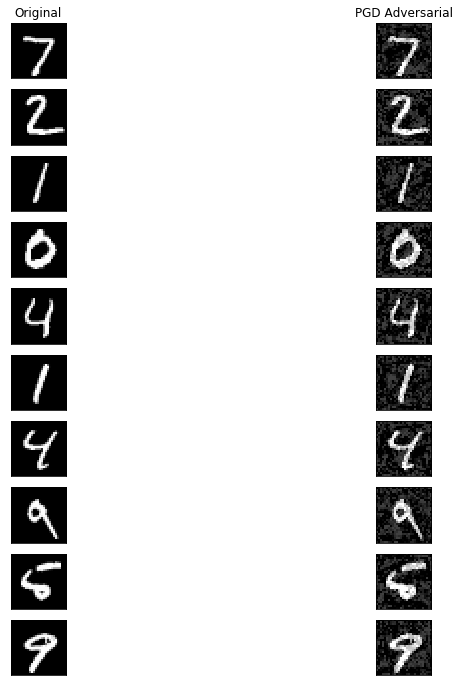

In [0]:
#Show ten original samples and their corresponding adversarial samples
num_samples = 10
fig1,ax1 = plt.subplots(num_samples,2)
fig1.set_size_inches(12,12)
titles=['Original','PGD Adversarial']
for i in range(2): ax1[0,i].set_title(titles[i])
for i in range(num_samples):
  #original 
  ax1[i,0].imshow(X_test[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,0].get_xaxis().set_visible(False)
  ax1[i,0].get_yaxis().set_visible(False)
  #adversarial
  ax1[i,1].imshow(pgd_attack_onTest_data[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,1].get_xaxis().set_visible(False)
  ax1[i,1].get_yaxis().set_visible(False)

plt.show()

In [0]:
#Implementing the adversarial training defense
#Create instance of classifier
adv_trained_clf = MNIST_Classifier()

#Compile model using an appropriate loss and optimizer algorithm
adv_trained_clf.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

#Train the model and assign training meta-data to a variable
adv_trained_clf_mdata = adv_trained_clf.fit(np.vstack((X_train,pgd_attack_onTrain_data)),
                                            np.concatenate((labels_train,labels_train)),
                                         validation_data=(X_test,labels_test),
                                         epochs=50,
                                         batch_size=256,
                                         shuffle=True)

# save model and history
adv_trained_clf.save('adv_trained_clf.h5')
!cp adv_trained_clf.h5 /content/gdrive/My\ Drive/ML2/Project-4/

with open('adv_trained_clf_history.pkl', 'wb') as f:  
  pickle.dump(adv_trained_clf_mdata.history, f)

!cp adv_trained_clf_history.pkl /content/gdrive/My\ Drive/ML2/Project-4/

Train on 120000 samples, validate on 10000 samples
Epoch 1/50
120000/120000 [==============================] - 9s 79us/step - loss: 0.2080 - acc: 0.9393 - val_loss: 0.1474 - val_acc: 0.9534
Epoch 2/50
120000/120000 [==============================] - 5s 42us/step - loss: 0.0656 - acc: 0.9811 - val_loss: 0.1111 - val_acc: 0.9651
Epoch 3/50
120000/120000 [==============================] - 5s 43us/step - loss: 0.0442 - acc: 0.9866 - val_loss: 0.0924 - val_acc: 0.9719
Epoch 4/50
120000/120000 [==============================] - 5s 43us/step - loss: 0.0333 - acc: 0.9899 - val_loss: 0.0847 - val_acc: 0.9727
Epoch 5/50
120000/120000 [==============================] - 5s 42us/step - loss: 0.0250 - acc: 0.9922 - val_loss: 0.0904 - val_acc: 0.9727
Epoch 6/50
120000/120000 [==============================] - 5s 43us/step - loss: 0.0198 - acc: 0.9938 - val_loss: 0.0838 - val_acc: 0.9748
Epoch 7/50
120000/120000 [==============================] - 5s 43us/step - loss: 0.0165 - acc: 0.9948 - val_loss: 0

In [0]:
!cp /content/gdrive/My\ Drive/ML2/Project-4/adv_trained_clf.h5 ./
adv_trained_clf = load_model('adv_trained_clf.h5')

#Using the defense to evaluate the accuracy of the perturbed data
score_pgd_clf_advtest = adv_trained_clf.evaluate(pgd_attack_onTest_data,labels_test)
score_pgd_clf_benigntest = adv_trained_clf.evaluate(X_test,labels_test)

print('Accuracy of adversarial-trained-classifier on perturbed testing data: %0.2f%%'%(score_pgd_clf_advtest[1]*100))

# accuracy of new classifier on un-perturbed testing data
print('Accuracy of adversarial-trained-classifier on un-perturbed testing data: %0.2f%%'%(score_pgd_clf_benigntest[1]*100))

10000/10000 [==============================] - 1s 86us/step
Accuracy of adversarial-trained-classifier on perturbed testing data: 97.96%
Accuracy of adversarial-trained-classifier on un-perturbed testing data: 97.74%


#Part 4: Carlini and Wagner Attack

In [0]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
CW = CarliniWagnerL2(wrap, sess=sess)

#Attack parameters
CW_params = { 'binary_search_steps':1,
              "y": None,
              'learning_rate':1.25,
              'batch_size':16,
              'initial_const':10,
              'clip_min':0.0,
              'clip_max':1.0}

#Generate adversarial data
CW_attack_onTest_data =  CW.generate_np(X_test,**CW_params)              

#Evaluate accuracy of perturbed data on target 
CW_adv_scores = mnist_classifier.evaluate(CW_attack_onTest_data,labels_test)
print('CW Adversarial Attack Accuracy: %0.2f%%'%(CW_adv_scores[1]*100))

10000/10000 [==============================] - 3s 257us/step
CW Adversarial Attack Accuracy: 1.40%


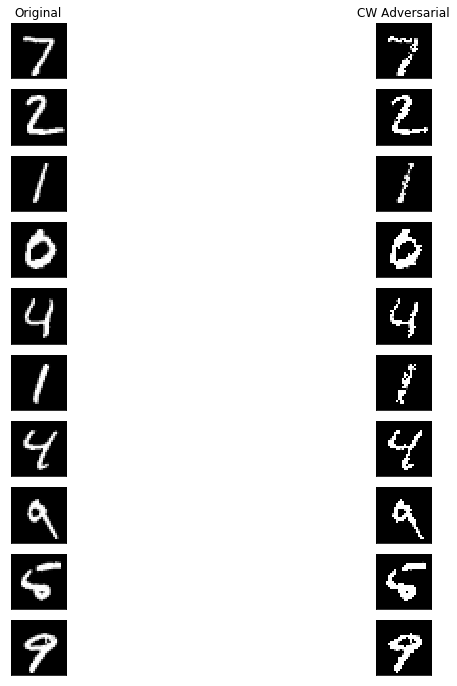

In [0]:
#Show ten original samples and their corresponding adversarial samples
num_samples = 10
fig1,ax1 = plt.subplots(num_samples,2)
fig1.set_size_inches(12,12)
titles=['Original','CW Adversarial']
for i in range(2): ax1[0,i].set_title(titles[i])
for i in range(num_samples):
  #original 
  ax1[i,0].imshow(X_test[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,0].get_xaxis().set_visible(False)
  ax1[i,0].get_yaxis().set_visible(False)
  #adversarial
  ax1[i,1].imshow(CW_attack_onTest_data[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,1].get_xaxis().set_visible(False)
  ax1[i,1].get_yaxis().set_visible(False)

plt.show()

In [0]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(X_train)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)

#Transform perturbed CW data using the subspace from the original training data
#pca_CW_train = pca.transform(CW_attack_onTrain_data)
pca_CW_test = pca.transform(CW_attack_onTest_data)

# create model for PCA
def pca_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=100))    
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu')) 
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax')) 
    return model

pca_classifier = pca_model()    

#Create model graph, compile it, and train it using pca_train lables_train 
#Compile model using an appropriate loss and optimizer algorithm
pca_classifier.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

#Train the model and assign training meta-data to a variable
pca_classifier_mdata = pca_classifier.fit(pca_train,labels_train,
                                         validation_data=(pca_test,labels_test),
                                         epochs=50,
                                         batch_size=256,
                                         shuffle=True)

# save model and history
pca_classifier.save('pca_classifier.h5')
!cp pca_classifier.h5 /content/gdrive/My\ Drive/ML2/Project-4/

with open('pca_classifier_history.pkl', 'wb') as f:  
  pickle.dump(pca_classifier_mdata.history, f)

!cp pca_classifier_history.pkl /content/gdrive/My\ Drive/ML2/Project-4/

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.4514 - acc: 0.8660 - val_loss: 0.1803 - val_acc: 0.9490
Epoch 2/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1536 - acc: 0.9559 - val_loss: 0.1276 - val_acc: 0.9645
Epoch 3/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1047 - acc: 0.9698 - val_loss: 0.1040 - val_acc: 0.9694
Epoch 4/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0772 - acc: 0.9777 - val_loss: 0.0892 - val_acc: 0.9731
Epoch 5/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.0608 - acc: 0.9826 - val_loss: 0.0831 - val_acc: 0.9756
Epoch 6/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0486 - acc: 0.9862 - val_loss: 0.0806 - val_acc: 0.9751
Epoch 7/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0385 - acc: 0.9896 - val_loss: 0.0764 - val_acc

In [0]:
!cp /content/gdrive/My\ Drive/ML2/Project-4/pca_classifier.h5 ./
pca_classifier = load_model('pca_classifier.h5')

#Using the defense (and comparing to baseline accuracy)
score_pca_clf_on_CW_Test_data = pca_classifier.evaluate(pca_CW_test,labels_test)
score_baseline_clf_on_CW_Test_data = mnist_classifier.evaluate(CW_attack_onTest_data,labels_test)
print('Accuracy of PCA-based defense classifier: %0.2f%% compared to baseline classifier: %0.2f%%'\
%(score_pca_clf_on_CW_Test_data[1]*100,score_baseline_clf_on_CW_Test_data[1]*100))


10000/10000 [==============================] - 1s 80us/step
Accuracy of PCA-based defense classifier: 85.54% compared to baseline classifier: 1.40%


#Part 5: DeepFool 

In [0]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
deepfool = DeepFool(wrap,sess= sess)

#Attack parameters
DF_params = { 'nb_candidate':10,
              'max_iter':50,
              'clip_min':0.0,
              'clip_max':1.0}

#Generate adversarial data
DF_attack_onTest_data = deepfool.generate_np(X_test,**DF_params)   

#Evaluate accuracy of perturbed data on target classifier
DF_adv_scores = mnist_classifier.evaluate(DF_attack_onTest_data,labels_test)
print('DF Adversarial Attack Accuracy: %0.2f%%'%(DF_adv_scores[1]*100))

10000/10000 [==============================] - 2s 176us/step
DF Adversarial Attack Accuracy: 1.42%


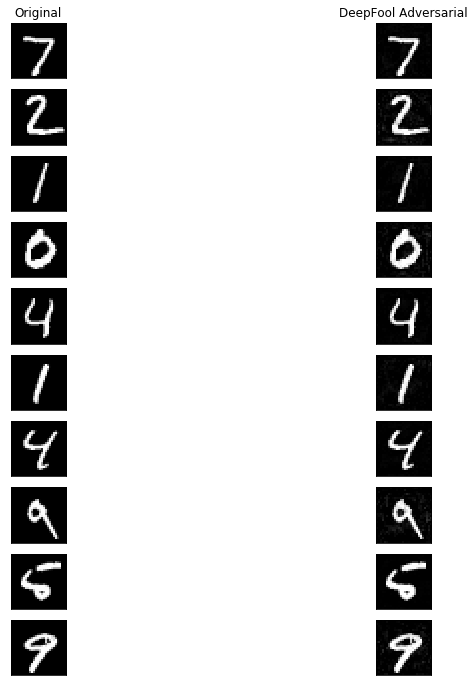

In [0]:
#Show ten original samples and their corresponding adversarial samples
num_samples = 10
fig1,ax1 = plt.subplots(num_samples,2)
fig1.set_size_inches(12,12)
titles=['Original','DeepFool Adversarial']
for i in range(2): ax1[0,i].set_title(titles[i])
for i in range(num_samples):
  #original 
  ax1[i,0].imshow(X_test[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,0].get_xaxis().set_visible(False)
  ax1[i,0].get_yaxis().set_visible(False)
  #adversarial
  ax1[i,1].imshow(DF_attack_onTest_data[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,1].get_xaxis().set_visible(False)
  ax1[i,1].get_yaxis().set_visible(False)

plt.show()

In [0]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
DF_attack_onTrain_data = deepfool.generate_np(X_train,**DF_params)   
data_total_train = np.concatenate([DF_attack_onTrain_data, X_train])

# df_attack_data_train = deepfool.generate_np(X_train, **fgm_params)
# data_total_train = np.concatenate([df_attack_data_train, X_train])

#Create and train DAE graph
ae_df = autoencoder()

#Compile model using an appropriate loss and optimizer algorithm
ae_df.compile(loss="mean_squared_error",optimizer="adam")

#Train the model and assign training meta-data to a variable
num_epochs = 50
batch_size = 256

ae_df_history = ae_df.fit(data_total_train,
                          np.concatenate([X_train, X_train]),
                          epochs = num_epochs,
                          batch_size = batch_size,
                          shuffle=True)

# save model
ae_df.save('ae_df.h5')
!cp ae_df.h5 /content/gdrive/My\ Drive/ML2/Project-4/

W1111 20:12:46.993799 140199666685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Epoch 1/50
120000/120000 [==============================] - 6s 52us/step - loss: 0.0255
Epoch 2/50
120000/120000 [==============================] - 5s 40us/step - loss: 0.0079
Epoch 3/50
120000/120000 [==============================] - 5s 39us/step - loss: 0.0056
Epoch 4/50
120000/120000 [==============================] - 5s 41us/step - loss: 0.0045
Epoch 5/50
120000/120000 [==============================] - 5s 41us/step - loss: 0.0038
Epoch 6/50
120000/120000 [==============================] - 5s 40us/step - loss: 0.0033
Epoch 7/50
120000/120000 [==============================] - 5s 41us/step - loss: 0.0030
Epoch 8/50
120000/120000 [==============================] - 5s 40us/step - loss: 0.0028
Epoch 9/50
120000/120000 [==============================] - 5s 40us/step - loss: 0.0026
Epoch 10/50
120000/120000 [==============================] - 5s 40us/step - loss: 0.0024
Epoch 11/50
120000/120000 [==============================] - 5s 40us/step - loss: 0.0023
Epoch 12/50
120000/120000 [===

In [0]:
!cp /content/gdrive/My\ Drive/ML2/Project-4/ae_df.h5 ./
ae_df = load_model('ae_df.h5')

#Using the defense

#Use DAE to to remove adversarial perturbation 
reconstructions_ae_df_on_DF_Test_data = ae_df.predict(DF_attack_onTest_data)

#Evaluate accuracy of DF samples after denoising 
score_denoised_DF_Test_samples = mnist_classifier.evaluate(reconstructions_ae_df_on_DF_Test_data,labels_test)
print('Accuracy of denoised-DF samples: %0.2f%%'%(score_denoised_DF_Test_samples[1]*100))

10000/10000 [==============================] - 1s 74us/step
Accuracy of denoised-DF samples: 97.91%


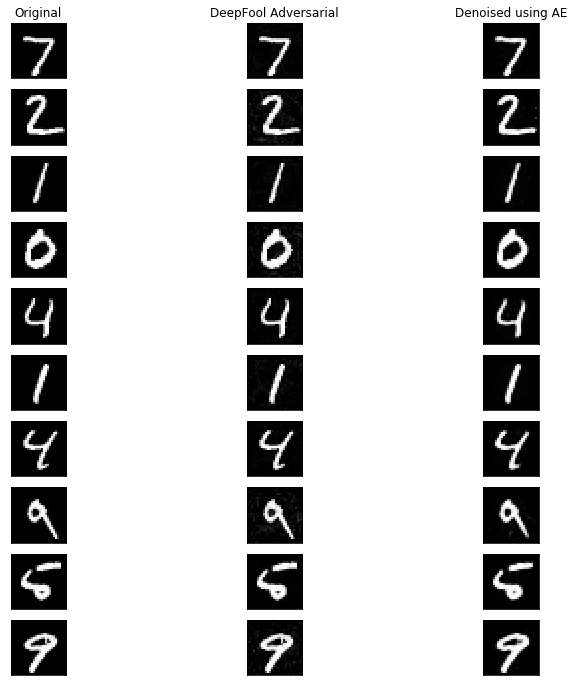

In [0]:
#Show ten samples of adversarial samples after denoising
num_samples = 10
fig1,ax1 = plt.subplots(num_samples,3)
fig1.set_size_inches(12,12)
titles=['Original','DeepFool Adversarial','Denoised using AE']
for i in range(3): ax1[0,i].set_title(titles[i])
for i in range(num_samples):
  #original 
  ax1[i,0].imshow(X_test[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,0].get_xaxis().set_visible(False)
  ax1[i,0].get_yaxis().set_visible(False)
  #adversarial
  ax1[i,1].imshow(DF_attack_onTest_data[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,1].get_xaxis().set_visible(False)
  ax1[i,1].get_yaxis().set_visible(False)
  #denoised
  ax1[i,2].imshow(reconstructions_ae_df_on_DF_Test_data[i].reshape(28,28),cmap=plt.cm.gray)
  ax1[i,2].get_xaxis().set_visible(False)
  ax1[i,2].get_yaxis().set_visible(False)
plt.show()